<h1>Analyse the reason why active plaintiffs exit</h1>

In [238]:
#coding:utf-8
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import numpy as np
import re
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import os
import cn2an
import chinese2digits as c2d
import operator
import plotly.express as px
import plotly
import plotly.graph_objects as go
import plotly as py
import plotly.offline as offline
offline.init_notebook_mode(connected=True)
from urllib.request import urlopen
import json
import requests
from plotly.subplots import make_subplots
from matplotlib import pyplot as plt
from collections import Counter
import seaborn as sns
mapbox_access_token = "pk.eyJ1Ijoic3RhcmljZSIsImEiOiJjazN6Y2s5dTUxY2R6M2xxcHllbXk4YWFzIn0.lActFqLzqRWGn7dqr4BShw"
px.set_mapbox_access_token(mapbox_access_token)

In [3]:
# 在后面绘制地区区域划分图会用到
with open("/Users/starice/OwnFiles/cityu/RA/case_study/code/case_process/china_province.geojson") as f:
    provinces_map = json.load(f)

In [4]:
all_cases = pd.read_csv('/Users/starice/OwnFiles/cityu/RA/case_study/data/total_extracted_result/all_cases.csv', encoding="utf-8")
#获取所有一审案件
first_cases = all_cases[all_cases['procedure']=="一审"]
# 获取所有案件原告的节点度并排序
degree_1stplaintiffs = first_cases.groupby("plaintiff")['case_id'].unique().reset_index()
degree_1stplaintiffs['case_count'] = degree_1stplaintiffs['case_id'].apply(lambda r: len(r))
degree_1stplaintiffs.sort_values(by="case_count", inplace=True, ascending=False)

<h2>2.4 活跃原告退出的原因分析（胜率，金额等等， 以前1000个为例），接activePlaintiffPatterns2</h2><br>
<p>可能的原因：<br>
    1. 退出前一年赢率是否下降, <br>
    2. 退出前一年获得的惩罚金是否下降, <br>
    3. 职业生涯中赢率下降次数, <br>
    4. 职业生涯中惩罚金下降次数, <br>
    5. 职业生涯整体赢率下降了多少, <br>
    6. 职业生涯整体获得的惩罚金下降了多少, <br>
    7. 职业生涯整体赢率平均数, <br>
    8. 职业生涯整体获得的惩罚金平均数<br>
</p><br>
<p>活跃原告退出的定义: <br>
    1. 退出到再提起上诉（如果没有就是2020年）超过一年<br>
</p>

<h3>Build Data</h3>

In [5]:
fps_1000 = degree_1stplaintiffs[:1000]
n1stcp_1000 = first_cases[first_cases['plaintiff'].isin(fps_1000['plaintiff'])]
# nselected_1stcp_1000 = first_cases
n1stcp_1000.drop(n1stcp_1000[n1stcp_1000['plaintiff'].isin(["XX", "xx", "**", '', '***', 'x', 'X'])].index, inplace=True)
n1stcp_1000.head()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Unnamed: 0,case_id,judgement_date,is_success,court_name,procedure,judge,legalfee,objectmoney,province,city,reason,district,penalty,year,month,day,plaintiff,defendant,lawyer
4,4,57abb74ac2265c258984430a,2014-01-28,TRUE,嘉善县人民法院,一审,吕学强,25.0,450.0,浙江省,嘉兴市,民事案由,嘉善县,450.0,2014,1,28,白世桥,嘉善大润发商业有限公司,NaN
28,28,57babb26c2265c5f452d3408,2014-01-08,TRUE,宁陕县人民法院,一审,王晓,50.0,18.0,陕西省,安康市,买卖合同纠纷,宁陕县,180.0,2014,1,8,孙安民,宁陕县永乐商贸有限公司,NaN
34,34,5842f0a72f12c650631af80b,2014-01-20,TRUE,北京市昌平区人民法院,一审,尤文静,25.0,319.0,北京市,北京市,买卖合同纠纷,昌平区,3196.0,2014,1,20,宫效伟,北京华联综合超市股份有限公司昌平分公司,NaN
35,35,5842f0a72f12c650631af80b,2014-01-20,TRUE,北京市昌平区人民法院,一审,尤文静,25.0,319.0,北京市,北京市,买卖合同纠纷,昌平区,3196.0,2014,1,20,宫效伟,北京华联综合超市股份有限公司,NaN
38,38,57b80934c2265c6884a39558,2014-01-06,TRUE,上海市长宁区人民法院,一审,陈婷婷,25.0,356.0,上海市,上海市,买卖合同纠纷,长宁区,3560.0,2014,1,6,阎家明,上海元立投资管理有限公司,张钧


In [39]:
def split_num_l(num_lst):
    """merge successive num, sort lst(ascending or descending): 'as' or 'des'
    eg: [1, 3,4,5,6, 9,10] -> [[1], [3, 4, 5, 6], [9, 10]]
    """
    num_lst_tmp = [int(n) for n in num_lst]
    sort_lst = sorted(num_lst_tmp)  # ascending
    len_lst = len(sort_lst)
    i = 0
    split_lst = []
    
    tmp_lst = [sort_lst[i]]
    dif_lst = {}
    while True:
        if i + 1 == len_lst:
            break
        next_n = sort_lst[i+1]
        if sort_lst[i] + 1 == next_n:
            tmp_lst.append(next_n)
        else:
#             dif_lst.append(next_n - sort_lst[i])
            split_lst.append(tmp_lst)
            dif_lst[next_n - sort_lst[i]] = tmp_lst
            tmp_lst = [next_n]
        i += 1
    split_lst.append(tmp_lst)
    return dif_lst

def is_exit(row):
    
    row['is_exit'] = 0
    if (2020 - row['final_year'] >= 2 and row['year'] == row['final_year']): row['is_exit'] = 1
    if len(row['splitted_years']) > 1:
        for k, v in row['splitted_years'].items():
            if k >= 2 and row['year'] == v[-1]:
                row['is_exit'] = 1
    return row
split_num_l([1, 2, 5, 6, 7, 23, 24, 25])

{3: [1, 2], 16: [5, 6, 7]}

In [358]:
# 重新定义活跃分子退出
# 找到所有符合退出条件的活跃原告
# 构建feature数据
def build_data(oriDf, features):
    
    gb1stcp_1000 = n1stcp_1000.groupby(['plaintiff', 'year'])['case_id'].nunique().reset_index()
    df1 = n1stcp_1000.groupby('plaintiff').apply(lambda x: sorted(list(set(x['year'])))).reset_index() 
    df1['final_year'] = df1[0].apply(lambda x: max(x))
    df1['len_years'] = df1[0].apply(lambda x: len(x))
    df1['splitted_years'] = df1[0].apply(lambda x: split_num_l(x))
    # df1 = df1.apply(lambda row: is_exit(row), axis=1)
    gb1stcp_1000 = gb1stcp_1000.merge(df1, how="left")
    gb1stcp_1000 = gb1stcp_1000.apply(lambda row: is_exit(row), axis=1)
    gb1stcp_1000 = gb1stcp_1000

    tpf_nselected_1stcp_cc = n1stcp_1000.groupby(['plaintiff', 'year'])['case_id'].nunique().reset_index()
    tpf_nselected_1stcp_sc = n1stcp_1000[n1stcp_1000['is_success']=="TRUE"].groupby(['plaintiff', 'year'])['case_id'].nunique().reset_index()
    tpf_nselected_1stcp_sc.rename(columns={"case_id": "success_count"}, inplace=True)
    tpf_nselected_1stcp = tpf_nselected_1stcp_cc.merge(tpf_nselected_1stcp_sc, how="left")
    tpf_nselected_1stcp.fillna(0, inplace=True)
    tpf_nselected_1stcp.rename(columns={"case_id": "case_count"}, inplace=True)
    tpf_nselected_1stcp['success_rate'] = tpf_nselected_1stcp['success_count'] / tpf_nselected_1stcp['case_count']
    # display(tpf_nselected_1stcp.head())

    tpf_nselected_1stcp_mc = n1stcp_1000.groupby(['plaintiff', 'year'])['penalty'].sum().reset_index()
    tpf_nselected_1stcp_om = n1stcp_1000.groupby(['plaintiff', 'year'])['objectmoney'].sum().reset_index()
    tpf_nselected_1stcp = tpf_nselected_1stcp.merge(tpf_nselected_1stcp_mc)
    tpf_nselected_1stcp = tpf_nselected_1stcp.merge(tpf_nselected_1stcp_om)

    gbtpf1stcp_1000 = gb1stcp_1000.merge(tpf_nselected_1stcp, on=['plaintiff', 'year'], how="left")
    gbtpf1stcp_1000['sr_last_year'] = gbtpf1stcp_1000.groupby('plaintiff')['success_rate'].shift()
    gbtpf1stcp_1000['penalty_last_year'] = gbtpf1stcp_1000.groupby('plaintiff')['penalty'].shift()

    gbtpf1stcp_1000['sr_1yr_drop'] = gbtpf1stcp_1000['success_rate'] - gbtpf1stcp_1000['sr_last_year']
    gbtpf1stcp_1000['penalty_1yr_drop'] = gbtpf1stcp_1000['penalty'] - gbtpf1stcp_1000['penalty_last_year']
    gbtpf1stcp_1000['total_active_years'] = gbtpf1stcp_1000[0].apply(lambda x: len(x))
    gbtpf1stcp_1000.fillna(0, inplace=True)

    gbtpf1stcp_1000 = gbtpf1stcp_1000.join(gbtpf1stcp_1000.groupby('plaintiff')['sr_1yr_drop'].apply(lambda r: sum(r<0)), on='plaintiff', rsuffix='_count')
    gbtpf1stcp_1000 = gbtpf1stcp_1000.join(gbtpf1stcp_1000.groupby('plaintiff')['penalty_1yr_drop'].apply(lambda r: sum(r<0)), on='plaintiff', rsuffix='_count')

    gbtpf1stcp_1000 = gbtpf1stcp_1000.join(gbtpf1stcp_1000.groupby('plaintiff')['sr_1yr_drop'].apply(lambda r: r[r<0].sum()) , on='plaintiff', rsuffix='_sum')
    gbtpf1stcp_1000 = gbtpf1stcp_1000.join(gbtpf1stcp_1000.groupby('plaintiff')['penalty_1yr_drop'].apply(lambda r: r[r<0].sum()), on='plaintiff', rsuffix='_sum')


    gbtpf1stcp_1000 = gbtpf1stcp_1000.join(gbtpf1stcp_1000.groupby('plaintiff')['success_rate'].mean(), on='plaintiff', rsuffix='_mean')
    gbtpf1stcp_1000 = gbtpf1stcp_1000.join(gbtpf1stcp_1000.groupby('plaintiff')['penalty'].mean(), on='plaintiff', rsuffix='_mean')
    gbtpf1stcp_1000 = gbtpf1stcp_1000.join(gbtpf1stcp_1000.groupby('plaintiff')['objectmoney'].mean(), on='plaintiff', rsuffix='_mean')


    gbtpf1stcp_1000['sr_1yr_drop_sum'] = abs(gbtpf1stcp_1000['sr_1yr_drop_sum'])
    gbtpf1stcp_1000['penalty_1yr_drop_sum'] = abs(gbtpf1stcp_1000['penalty_1yr_drop_sum'])

    # display(gbtpf1stcp_1000.head())
    gbtpf1stcp_1000 = gbtpf1stcp_1000[gbtpf1stcp_1000['year']==gbtpf1stcp_1000['final_year']]
    gbtpf1stcp_1000['sr_1yr_drop_bool'] = gbtpf1stcp_1000['sr_1yr_drop'].apply(lambda r: True if r<0 else False)
    gbtpf1stcp_1000['penalty_1yr_drop_bool'] = gbtpf1stcp_1000['penalty_1yr_drop'].apply(lambda r: True if r<0 else False)

    gbtpf1stcp_1000['sr_1yr_drop'] = abs(gbtpf1stcp_1000['sr_1yr_drop'])
    gbtpf1stcp_1000['penalty_1yr_drop'] = abs(gbtpf1stcp_1000['penalty_1yr_drop'])

    gbtpf1stcp_1000 = gbtpf1stcp_1000[features]
    gbtpf1stcp_1000.head()
    return gbtpf1stcp_1000

In [424]:
gbtpf1stcp_1000 = build_data(n1stcp_1000, ['plaintiff', 'year', 
                                       'total_active_years', 'is_exit', 
                                       'sr_1yr_drop', 'penalty_1yr_drop', 
                                       'sr_1yr_drop_count', 'penalty_1yr_drop_count', 
                                       'success_rate_mean', 'penalty_mean', 
                                       'sr_1yr_drop_sum', 'penalty_1yr_drop_sum', 
                                       'sr_1yr_drop_bool', 'penalty_1yr_drop_bool'])

<h3>Classification</h3>

In [425]:
# 样本分配(可以看出基本均衡)
gbtpf1stcp_1000['is_exit'].value_counts()

1    515
0    485
Name: is_exit, dtype: int64

In [426]:
features = [
    'sr_1yr_drop', # how much has the sr dropped since the last year
    'penalty_1yr_drop', # how much has the penalty dropped since the last year
    'sr_1yr_drop_count', # how many times the sr dropped during the whole period
    'penalty_1yr_drop_count', # how many times the penalty dropped during the whole period
    'sr_1yr_drop_bool', # whether the sr dropped from last year
    'penalty_1yr_drop_bool', # whether the penalty dropped from last year
    'success_rate_mean', # mean sr for the whole period
    'penalty_mean', # mean penalty for the whole period
    'sr_1yr_drop_sum', # total dropped sr for the whole period
    'penalty_1yr_drop_sum',  # total dropped penalty for the whole period
    'total_active_years'
]

<h4>Pearson correlation coefficient</h4>

<AxesSubplot:>

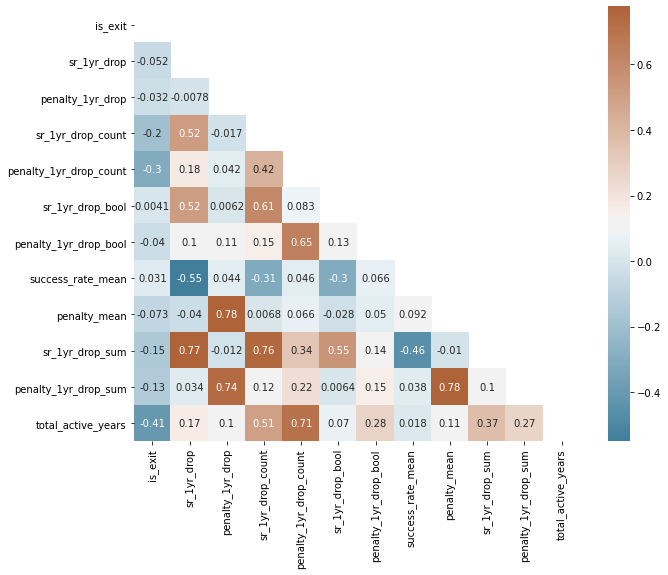

In [427]:
cmap = sns.diverging_palette(230, 30, as_cmap=True)
corr = gbtpf1stcp_1000[['is_exit'] + features].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10,8))
sns.heatmap(
    corr, 
    annot = True, 
    mask = mask, 
    cmap = cmap
)

<h4>Logistic Regression</h4>

In [428]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

#活跃原告活跃的最后一年的赢率下降程度和获得的惩罚金下降程度是否影响其退出
#目前退出的数据量和未退出的数据量基本相同(500左右)，可以做分类分析
#结果显示并无特别关联的可能
X = gbtpf1stcp_1000[features].values
y = gbtpf1stcp_1000['is_exit'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
clf = LogisticRegressionCV(cv=5, random_state=1).fit(X_train, y_train)
# clf.score(X_test, y_test)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.52      0.61      0.56       132
           1       0.65      0.57      0.60       168

    accuracy                           0.58       300
   macro avg       0.58      0.59      0.58       300
weighted avg       0.59      0.58      0.58       300



<h4>Random Forest</h4>

In [429]:
# select features
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

model_tree = RandomForestClassifier(random_state=100, n_estimators=50)
model_tree.fit(X_train, y_train)
y_pred = model_tree.predict(X_test)
print(classification_report(y_test, y_pred))

print(model_tree.feature_importances_)
sel_model_tree = SelectFromModel(estimator=model_tree, prefit=True, threshold='mean') 

# since we already fit the data, we specify prefit option here
# Features whose importance is greater or equal to the threshold are kept while the others are discarded.
X_train_sfm_tree = sel_model_tree.transform(X_train)
selected = sel_model_tree.get_support()
print(selected)

              precision    recall  f1-score   support

           0       0.56      0.67      0.61       132
           1       0.70      0.58      0.63       168

    accuracy                           0.62       300
   macro avg       0.63      0.63      0.62       300
weighted avg       0.64      0.62      0.62       300

[0.06096964 0.17946677 0.01597864 0.0511816  0.01350174 0.0177423
 0.09011792 0.23653989 0.04784058 0.14596238 0.14069854]
[False  True False False False False False  True False  True  True]


In [442]:
# After selecting the features
selected_features = [features[i] for i in range(len(features)) if selected[i]==True]
print(selected_features)

newX = gbtpf1stcp_1000[selected_features].values
y = gbtpf1stcp_1000['is_exit'].values
newX_train, newX_test, newy_train, newy_test = train_test_split(newX, y, test_size=0.3)

model_tree = RandomForestClassifier(random_state=100, n_estimators=50)
model_tree.fit(newX_train, newy_train)
newy_pred = model_tree.predict(newX_test)
print(classification_report(newy_test, newy_pred))

['penalty_1yr_drop', 'penalty_mean', 'penalty_1yr_drop_sum', 'total_active_years']
              precision    recall  f1-score   support

           0       0.63      0.64      0.64       143
           1       0.67      0.66      0.67       157

    accuracy                           0.65       300
   macro avg       0.65      0.65      0.65       300
weighted avg       0.65      0.65      0.65       300



<h4>RandomForest 调参</h4>

In [443]:
from pprint import pprint

# 1. Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(model_tree.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 50,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 100,
 'verbose': 0,
 'warm_start': False}


In [446]:
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
from sklearn.model_selection import RandomizedSearchCV

# 2. Build parameters set and randomly choose them to find the local optimal parameters through RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 8]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4, 8],
 'min_samples_split': [2, 5, 10, 20],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [447]:
# 3. Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   59.2s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.0min finished


{'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'auto', 'max_depth': 20, 'bootstrap': True}


In [448]:
# 4. Train model with selected parameters and check the performance on our test data set
model_tree = RandomForestClassifier(
    n_estimators = 800, 
    min_samples_split = 5, 
    min_samples_leaf = 8, 
    max_features = 'auto', 
    max_depth = 20, 
    bootstrap = True, 
    random_state = 1
)

model_tree.fit(X_train, y_train)
y_pred = model_tree.predict(X_test)
print(classification_report(y_test, y_pred))

print(model_tree.feature_importances_)
sel_model_tree = SelectFromModel(estimator=model_tree, prefit=True, threshold='mean') 

X_train_sfm_tree = sel_model_tree.transform(X_train)
selected = sel_model_tree.get_support()
print(selected)

# After selecting the features
selected_features = [features[i] for i in range(len(features)) if selected[i]==True]
print(selected_features)

              precision    recall  f1-score   support

           0       0.59      0.61      0.60       132
           1       0.68      0.67      0.68       168

    accuracy                           0.64       300
   macro avg       0.64      0.64      0.64       300
weighted avg       0.64      0.64      0.64       300

[0.04711826 0.13870358 0.02184449 0.08215642 0.00903435 0.01690645
 0.06205694 0.1384449  0.04280338 0.16223915 0.27869207]
[False  True False False False False False  True False  True  True]
['penalty_1yr_drop', 'penalty_mean', 'penalty_1yr_drop_sum', 'total_active_years']


In [453]:
newX = gbtpf1stcp_1000[selected_features].values
y = gbtpf1stcp_1000['is_exit'].values
newX_train, newX_test, newy_train, newy_test = train_test_split(newX, y, test_size=0.2)

model_tree.fit(newX_train, newy_train)
newy_pred = model_tree.predict(newX_test)
print(classification_report(newy_test, newy_pred))

              precision    recall  f1-score   support

           0       0.68      0.61      0.64        99
           1       0.65      0.72      0.69       101

    accuracy                           0.67       200
   macro avg       0.67      0.66      0.66       200
weighted avg       0.67      0.67      0.66       200



<h4>GBDT</h4>

In [458]:
from sklearn.ensemble import GradientBoostingClassifier

gbr = GradientBoostingClassifier(n_estimators=800, max_depth=20, min_samples_split=2, learning_rate=0.1)
gbr.fit(X_train, y_train.ravel())
y_pred = gbr.predict(X_test)
print(classification_report(y_test, y_pred))

gbr = GradientBoostingClassifier(n_estimators=800, max_depth=20, min_samples_split=2, learning_rate=0.1)
gbr.fit(newX_train, newy_train.ravel())
newy_pred = gbr.predict(newX_test)
print(classification_report(newy_test, newy_pred))

              precision    recall  f1-score   support

           0       0.51      0.63      0.56       132
           1       0.64      0.52      0.57       168

    accuracy                           0.57       300
   macro avg       0.57      0.57      0.57       300
weighted avg       0.58      0.57      0.57       300

              precision    recall  f1-score   support

           0       0.62      0.57      0.59        99
           1       0.61      0.66      0.64       101

    accuracy                           0.61       200
   macro avg       0.62      0.61      0.61       200
weighted avg       0.62      0.61      0.61       200



<h3>Classification on all possible variables</h3>

<p>可能的原因：<br>
    1. 退出前一年赢率是否下降, <br>
    2. 退出前一年获得的惩罚金是否下降, <br>
    3. 职业生涯中赢率下降次数, <br>
    4. 职业生涯中惩罚金下降次数, <br>
    5. 职业生涯整体赢率下降了多少, <br>
    6. 职业生涯整体获得的惩罚金下降了多少, <br>
    7. 职业生涯整体赢率平均数, <br>
    8. 职业生涯整体获得的惩罚金平均数<br>
    --------------------下面是新增变量--------------------<br>
    9. 标的平均数<br>
    10 ...
</p><br>

In [459]:
new_features = features = [
    'sr_1yr_drop', # how much has the sr dropped since the last year
    'penalty_1yr_drop', # how much has the penalty dropped since the last year
    'sr_1yr_drop_count', # how many times the sr dropped during the whole period
    'penalty_1yr_drop_count', # how many times the penalty dropped during the whole period
    'sr_1yr_drop_bool', # whether the sr dropped from last year
    'penalty_1yr_drop_bool', # whether the penalty dropped from last year
    'success_rate_mean', # mean sr for the whole period
    'penalty_mean', # mean penalty for the whole period
    'sr_1yr_drop_sum', # total dropped sr for the whole period
    'penalty_1yr_drop_sum',  # total dropped penalty for the whole period
    'total_active_years', 
    'objectmoney_mean'
]

In [460]:
new_gbtpf1stcp_1000 = build_data(n1stcp_1000, ['plaintiff', 'year', 
                                       'total_active_years', 'is_exit', 
                                       'sr_1yr_drop', 'penalty_1yr_drop', 
                                       'sr_1yr_drop_count', 'penalty_1yr_drop_count', 
                                       'success_rate_mean', 'penalty_mean', 
                                       'sr_1yr_drop_sum', 'penalty_1yr_drop_sum', 
                                       'sr_1yr_drop_bool', 'penalty_1yr_drop_bool', 'objectmoney_mean'])

In [461]:
new_gbtpf1stcp_1000.head()

,plaintiff,year,total_active_years,is_exit,sr_1yr_drop,penalty_1yr_drop,sr_1yr_drop_count,penalty_1yr_drop_count,success_rate_mean,penalty_mean,sr_1yr_drop_sum,penalty_1yr_drop_sum,sr_1yr_drop_bool,penalty_1yr_drop_bool,objectmoney_mean
3,丁字林,2018,4,1,1.000000,0.0,1,1,0.500000,18292.000,1.000000,73168.0,False,False,4279.000000
7,万峰,2019,4,0,0.500000,10020.0,2,2,0.825000,83905.000,0.500000,324600.0,False,True,19043.950000
12,丛李松,2018,5,1,0.153846,161063.0,2,2,0.957466,61198.720,0.212670,192231.6,False,True,5812.040000
16,严明,2019,4,0,0.000000,44855.0,1,2,0.982143,87528.125,0.071429,189157.5,False,True,6660.887500
19,严晋,2019,3,0,0.250000,20190.0,1,2,0.916667,38810.000,0.250000,25680.0,True,True,5704.333333


In [462]:
X = new_gbtpf1stcp_1000[new_features].values
y = new_gbtpf1stcp_1000['is_exit'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [464]:
model_tree = RandomForestClassifier(
    n_estimators = 800, 
    min_samples_split = 2, 
    min_samples_leaf = 1, 
    max_features = 'sqrt', 
    max_depth = 100, 
    bootstrap = True, 
    random_state = 100
) # parameters here are also selected as before

model_tree.fit(X_train, y_train)
y_pred = model_tree.predict(X_test)
print(classification_report(y_test, y_pred))

print(model_tree.feature_importances_)
sel_model_tree = SelectFromModel(estimator=model_tree, prefit=True, threshold='mean') 

X_train_sfm_tree = sel_model_tree.transform(X_train)
selected = sel_model_tree.get_support()
print(selected)

# After selecting the features
selected_features = [features[i] for i in range(len(new_features)) if selected[i]==True]
print(selected_features)

              precision    recall  f1-score   support

           0       0.68      0.59      0.63       146
           1       0.66      0.74      0.70       154

    accuracy                           0.67       300
   macro avg       0.67      0.66      0.66       300
weighted avg       0.67      0.67      0.66       300

[0.05153919 0.13834336 0.01679073 0.0496919  0.01047522 0.01610914
 0.08133888 0.16730294 0.04521515 0.11610265 0.11591475 0.1911761 ]
[False  True False False False False False  True False  True  True  True]
['penalty_1yr_drop', 'penalty_mean', 'penalty_1yr_drop_sum', 'total_active_years', 'objectmoney_mean']


In [469]:
newX = new_gbtpf1stcp_1000[selected_features].values
y = new_gbtpf1stcp_1000['is_exit'].values
newX_train, newX_test, newy_train, newy_test = train_test_split(newX, y, test_size=0.2)

model_tree.fit(newX_train, newy_train)
newy_pred = model_tree.predict(newX_test)
print(classification_report(newy_test, newy_pred))

              precision    recall  f1-score   support

           0       0.72      0.64      0.68        92
           1       0.72      0.79      0.75       108

    accuracy                           0.72       200
   macro avg       0.72      0.71      0.72       200
weighted avg       0.72      0.72      0.72       200



In [471]:
# output this ipynb to html with no code
!jupyter nbconvert activePlaintiffPatterns3.ipynb --to html

[NbConvertApp] Converting notebook activePlaintiffPatterns3.ipynb to html


<h3>It seems that 'penalty_1yr_drop', 
'penalty_mean', 
'penalty_1yr_drop_sum', 
'total_active_years' and 'objectmoney_mean' are meaningful features in deciding whether an active plaintiff will exit or not.</h3>